## Imports

In [1]:
import cobra
import numpy as np
import json
from cobra import Model, Reaction, Metabolite
import os
import pandas as pd
import logging
logging.getLogger("cobra").setLevel(logging.ERROR)

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

import seaborn as sns
sns.set_style("white")

## Funciones mapeo metabolitos

In [2]:
import re  # Asegurémonos de importar el módulo re para usarlo en las funciones
import libsbml
import csv
import pandas as pd
from fuzzywuzzy import fuzz
import json
import cobra

# Función para normalizar identificadores (IDs) con eliminación de prefijos y sufijos
def normalize_id(identifier, DB):
    """
    Normaliza un identificador eliminando caracteres especiales, convirtiéndolo a minúsculas,
    y eliminando prefijos y sufijos específicos si están presentes.
    
    Args:
        identifier (str): El identificador a normalizar.

    Returns:
        str: El identificador normalizado.
    """
    
    
    # Elimina prefijos y sufijos específicos
    prefixes = ["M_"]#, "R_"]
    #NJT
    if DB == 'bigg':
        suffixes = ["_e", "_p", "_c"] #depende de DB
    elif DB=='kegg':
        suffixes=['__extr', '__cytop', '__vacu', '__in', '__nucl', '__chlo', '__mito']
    elif DB=='metacyc':
        suffixes=["_e", "_p", "_c", "_t","_CCO__45__OUT", "_CCO__45__IN"]#"ccopmbacneg", "ccooutccoin"
    elif DB=='modelseed':
        suffixes = ["_c0", "_d0", "_g0", "_v0", "_w0", "_x0","_m0", "_n0", "_r0", "_e0", "_j0", "_c"]
        prefixes = ['m_']
    else:
        print('Database not found!')
        
        
    for prefix in prefixes:
        if identifier.startswith(prefix):
            identifier = identifier[len(prefix):]
            break
    for suffix in suffixes:
        
        if identifier.endswith(suffix):
            #print(identifier)
            #print(suffix)
            identifier = identifier[:-len(suffix)]
            break

    # Elimina caracteres especiales
    identifier = cobra.io.sbml._f_specie(identifier)
    identifier = re.sub(r"[^a-zA-Z0-9]+", "", identifier)
    # Convierte a minúsculas
    identifier = identifier.lower()
    return identifier

# Función para normalizar identificadores (IDs) sin eliminación de prefijos y sufijos
def normalize_id_no_prefix_suffix(identifier):
    """
    Normaliza un identificador eliminando caracteres especiales y convirtiéndolo a minúsculas.

    Args:
        identifier (str): El identificador a normalizar.

    Returns:
        str: El identificador normalizado.
    """
    # Elimina caracteres especiales
    identifier = re.sub(r"[^a-zA-Z0-9]+", "", identifier)
    
    # Convierte a minúsculas
    identifier = identifier.lower()
    
    return identifier

def gen_df(route_sbml, db_sbml, mnx_only=False):
    
    # read SBML
    document = libsbml.readSBMLFromFile(route_sbml)
    models = document.getModel()
    # Extraer los IDs originales de las especies del modelo
    species_ids = [species.getId() for species in models.getListOfSpecies()]
    #print(species_ids)
    #reaction_ids = [reaction.getId() for reaction in models.getListOfReactions()] #future considerations
    # Normalizar los IDs de las especies
    normalized_species_ids = [normalize_id(i, this_db) for i in species_ids]
    #for i in range(10):
    #    print(species_ids[i])
    #    print(normalized_species_ids[i])
    #1. metanetx
    df_map = map_mnx(this_db, species_ids, normalized_species_ids)
    print('mapping metanetx')
    print(df_map.head())
    #2. modelseed
    if not mnx_only:
        if db_sbml!='bigg':
            print('bigg map')
            df_map = map_bigg(df_map, this_db)
        if db_sbml!='modelseed':
            print('mapping modelseed')
            df_map = map_modelseed(df_map, this_db)

        print(df_map.head())
        #add name and formula for fuzzy
        print('adding name and formula')
        df_map = add_name_formula(models, df_map, this_db)
        print(df_map.head())

        #3. fuzzy wuzzys
        if db_sbml!='metacyc':
            print('fuzzy meta')
            df_map = fuzzy_map_meta(df_map)
            print(df_map.head())
        if db_sbml!='kegg':
            df_map = fuzzy_map_kegg(df_map)
            print('fuzzy kegg')
            print(df_map.head())
        if db_sbml!='modelseed':
            df_map = fuzzy_map_modelseed(df_map)
            print('fuzzy ms')
            print(df_map.head())
        if db_sbml!='bigg':
            print('fuzzy bigg')
            df_map = fuzzy_map_bigg(df_map)
            print(df_map.head())
        
    df_map = df_map.fillna('')
    return(df_map)

def gen_mnx_db_dict(chem_xref_file, db_out):
    #NJ adapted
    #generates dict mapping from MNX to a db_out database based on file from metanetx
    db_prefix_dict = {'bigg': 'biggM:', 'metacyc': 'metacycM:', 'kegg': 'kegg.compound:', 'modelseed': 'seedM:'}
    db_dict = {}
    with open(chem_xref_file, "r") as f:
        reader = csv.reader(f, delimiter="\t")
        for row in reader:
            if  row[0].startswith(db_prefix_dict[db_out]):
                out_id = row[0][len(db_prefix_dict[db_out]):]  # Eliminar los primeros 9 caracteres ("metacycM:")
                MNX = row[1]
                if out_id.startswith('M_'):#why? I removed it 28/11
                    out_id = out_id[2:]
                db_dict[MNX] = out_id
    return db_dict

def map_mnx(this_db, species_ids, normalized_species_ids, chem_xref_file = r"./DB/chem_xref.tsv"):
    #Map ids model to mnx
    #STEP 1: metanetx
    # Ruta al archivo de referencias
    # Crear un diccionario para las conversiones de bigg
    this_db_dict = {}
    for species_id, normalized_species_id in zip(species_ids, normalized_species_ids):
        this_db_dict[species_id] = (normalized_species_id,)
    # Crear un diccionario para las conversiones de Metanetx
    db_prefix_dict = {'bigg': 'biggM:', 'metacyc': 'metacycM:', 'kegg': 'kegg.compound:', 'modelseed': 'seedM:'}
    #this_db
    metanetx_dict = {}
    
    with open(chem_xref_file, "r") as f:
        reader = csv.reader(f, delimiter="\t")
        for row in reader:
            if row[0].startswith(db_prefix_dict[this_db]): #especifico DB
                id_orig = row[0][len(db_prefix_dict[this_db]):]  # Eliminar los primeros 6 caracteres ("biggM:") #id_orig comes from the id of the DB
                id_norm = normalize_id_no_prefix_suffix(id_orig)
                value = row[1]
                metanetx_dict[id_orig] = (id_norm, value) #tuple instead of single value
                
    
    
    other_dbs = list(db_prefix_dict.keys())
    other_dbs.remove(this_db)
    mnx_db_dicts = dict()
    for db in other_dbs:
        mnx_db_dicts[db] = gen_mnx_db_dict(chem_xref_file, db)

    # Convertir los diccionarios en DataFrames de pandas para bigg y Metanetx
    df_this = pd.DataFrame.from_dict(this_db_dict, orient='index', columns=['normalized_id'])
    df_this.index.name = 'original_id'

    # Crear una nueva columna llamada 'original_id' con los valores del índice
    df_this['original_id'] = df_this.index

    # Permutar las columnas y establecer 'normalized_id' como índice en df_bigg
    df_this = df_this[['normalized_id', 'original_id']].set_index('normalized_id', drop=True)
    # Convertir el diccionario metanetx_dict a un DataFrame de pandas
    df_metanetx = pd.DataFrame.from_dict(metanetx_dict, orient='index', columns=['normalized_id', 'MNX'])
    df_metanetx.index.name = 'original_id'
    print('df_metanetx')
    print(df_metanetx.head())
   
    # Crear una nueva columna llamada 'original_id' con los valores del índice y cambiar el nombre de la columna
    df_metanetx[this_db] = df_metanetx.index
    df_metanetx = df_metanetx.rename(columns={'original_id': this_db})
    
    # Permutar las columnas y establecer 'normalized_id' como índice en df_metanetx
    df_metanetx = df_metanetx[['normalized_id', 'MNX', this_db]].set_index('normalized_id', drop=True)

    # Realizar una fusión de los DataFrames de bigg y Metanetx en df_merged
    df_merged = df_this.merge(df_metanetx, how='left', left_index=True, right_index=True)
    #print('df_this.index')
    #print(df_this.index)
    #print('df_metanetx.index')
    #print(df_metanetx.index)
    
    df_no_data = df_merged.isna().all(axis=1)
    df_no_data.to_csv('no_data_rows.txt', header=False) #borrar?
    
    for db in other_dbs:
        #print(db)
        df_merged[db+'_mnx'] = df_merged['MNX'].map(mnx_db_dicts[db])
        
    # Restablecer el índice en df_merged y cambiar el nombre de la columna
    df_merged.reset_index(inplace=True)
    df_merged.rename(columns={'index': 'normalized_id'}, inplace=True)
    #print(df_merged.tail(10))
    return(df_merged)

def map_modelseed(df_merged, this_db, ruta_archivo = './DB/compounds.tsv'):

    # Definir la ruta del archivo TSV de modelseed
    ruta_archivo = './DB/compounds.tsv'

    # Definir la base de datos objetivo
    dict_obj_db = {'bigg':'BiGG', 'kegg': 'KEGG', 'metacyc':'MetaCyc'  }
    base_de_datos_objetivo = dict_obj_db[this_db]

    # Cargar el archivo TSV en un DataFrame de pandas
    df = pd.read_csv(ruta_archivo, sep='\t', header=None)

    # Crear un nuevo DataFrame para almacenar los identificadores
    df_nuevo = pd.DataFrame(columns=['Identificador', 'Modelseed_DB'])

    # Definir un patrón de búsqueda para "base_de_datos_objetivo: xxxx" con límites de palabra (\b)
    patron_busqueda = re.compile(rf'\b{base_de_datos_objetivo}: ([\w-]+)\b')

    # Iterar sobre las filas del DataFrame original y extraer los identificadores
    iden_dict = dict()
    for idx, row in df.iterrows():
        row_dict = dict()
        identificador_principal = row.iloc[0]
        for col in row[1:]:
            matches = patron_busqueda.findall(str(col))
            if matches:
                if len(matches)>1:
                    print(matches)
                identificador_encontrado = matches[0]
                #doing this with dicts instead: 
                row_dict['Identificador'] = identificador_encontrado
                row_dict['Modelseed_DB'] = identificador_principal
                iden_dict[idx] = row_dict
                # Agregar el identificador encontrado y su correspondiente 'Modelseed_DB' al DataFrame df_nuevo
                #df_nuevo = df_nuevo.append({'Identificador': identificador_encontrado, 'Modelseed_DB': identificador_principal}, ignore_index=True)
    df_nuevo = pd.DataFrame.from_dict(iden_dict, orient='index')
    # Realizar la combinación entre df_merged y df_nuevo utilizando 'Biggcyc_norm' e 'Identificador' como claves de combinación
    df_merged = df_merged.merge(df_nuevo, left_on=this_db, right_on='Identificador', how='left')

    # Eliminar la columna 'Identificador' del DataFrame resultante para limpiarlo
    df_merged.drop('Identificador', axis=1, inplace=True)
    
    return(df_merged)


def add_name_formula(models, df_merged, this_db, path_ms_db = './DB/compounds.tsv'):
    #input model in sbml
    #generate dicts with names and formulas
    #if this_db is modelseed, skip loading model and get formulas from database
    if this_db=='modelseed':
        df_ms = pd.read_csv(path_ms_db, sep='\t')
    name_dict = dict()
    formula_dict = dict()
    for met in models.getListOfSpecies():
        met_id = met.getIdAttribute()
        
        if met_id.startswith('M_'):
            met_id = met_id[2:]
        if this_db!='kegg':
            #clean compartment at the end (assuming it ends in "_c")
            #This could not be the case for other databases
            #print(met_id)
            if this_db=='modelseed':
                met_id = met_id[:-3]
            else:
                met_id = met_id[:-2]
            #print(met_id)
            
        if this_db=='modelseed':
            this_row = df_ms[df_ms['id']==met_id]
            if not this_row.empty:
                name_dict[met_id] = str(this_row['name'].iloc[0])
                formula_dict[met_id] = str(this_row['formula'].iloc[0])
            else:
                name_dict[met_id] = ''
                formula_dict[met_id] = ''
                
        else:
            name_dict[met_id] = met.getName()
             #met.getIdAttribute()
            notes = met.getNotesString()
            for n in notes.split('\n'):
                if 'FORMULA' in n:
                    formula = n.split(': ')[1].replace('</p>','')
                    formula_dict[met_id] = formula
            if not 'FORMULA' in notes:
                #print(notes)

                specie_fbc: "libsbml.FbcSpeciesPlugin" = met.getPlugin("fbc")
                if specie_fbc:
                    #charge = specie_fbc.getCharge()
                    formula = specie_fbc.getChemicalFormula() or ''
                    formula_dict[met_id] = formula
        # Agregar las columnas 'name' y 'formula' al DataFrame df_merged
    df_merged['name'] = ''
    df_merged['formula'] = ''

    # Iterar sobre cada fila del DataFrame df_merged y buscar el metabolito correspondiente en el modelo
    for index, row in df_merged.iterrows():
        #print(row[this_db])
        metabolito_id = row[this_db]#[2:]  # Obtén la cadena a partir del tercer carácter en adelante 
        #metabolito = modelo.metabolites.get_by_id(metabolito_id)

        # Obtener el nombre y la fórmula del metabolito
        if metabolito_id in name_dict.keys():
            #print('mapped name')
            nombre_metabolito = name_dict[metabolito_id]
            if metabolito_id in formula_dict.keys():
                formula_metabolito = formula_dict[metabolito_id]
            else:
                formula_metabolito = ''
        else:
            nombre_metabolito = ''
            formula_metabolito = ''

        # Agregar los valores de nombre y fórmula al DataFrame df_merged
        df_merged.at[index, 'name'] = nombre_metabolito
        df_merged.at[index, 'formula'] = formula_metabolito
        
    
    return(df_merged)
  

def map_bigg(df_merged, this_db, ruta_archivo='./DB/universal_model.json'):
    with open(ruta_archivo, 'r') as f:
        data = json.load(f)

    dict_obj_db = {'bigg':'BiGG', 'kegg': 'KEGG', 'metacyc':'MetaCyc', 'modelseed': 'modelseed' }
    base_de_datos_objetivo = dict_obj_db[this_db]
    # Crear una lista para almacenar los datos relevantes de los metabolitos
    metabolites = []
    for metabolite in data['metabolites']:
        bigg_id = metabolite['id']
        kegg_id = None
        seed_id = None
        metacyc_id = None
        mnx_id = None
        for annotation in metabolite['annotation']:
            #FALTA METACYC AQUI
            if 'kegg.compound' in annotation[1]:
                # Extraer el identificador kegg.compound de la anotación
                kegg_id = annotation[1].split('/')[-1]
            if 'seed.compound' in annotation[1]:
                # Extraer el identificador Modelseed de la anotación
                seed_id = annotation[1].split('/')[-1]
            if 'biocyc' in annotation[1]:
                # Extraer el identificador Metacyc de la anotación
                metacyc_id = annotation[1].split('/')[-1].replace('META:', '')
            if 'metanetx.chemical' in annotation[1]:
                # Extraer el identificador Metanetx de la anotación
                mnx_id = annotation[1].split('/')[-1]
            
        # Agregar los datos de metabolito a la lista
        metabolites.append({'BiGG': bigg_id, 'KEGG': kegg_id, 'modelseed': seed_id, 'MetaCyc': metacyc_id, 'Mnx': mnx_id})

    # Crear un DataFrame a partir de la lista de metabolitos
    df_metabolites = pd.json_normalize(metabolites)

    # Aplicar la función de normalización a la columna "See" después de reemplazar valores nulos con una cadena vacía
    df_metabolites[base_de_datos_objetivo+'_norm'] = df_metabolites[base_de_datos_objetivo].fillna('').apply(normalize_id_no_prefix_suffix)

    # Crear una nueva columna en df_merged para almacenar identificadores Bigg universales
    df_merged['bigg_DB'] = ''

    # Iterar sobre cada fila en df_merged
    for i, row in df_merged.iterrows():
        # Buscar si hay una coincidencia en "kegg_norm" en df_metabolites
        idx = df_metabolites.index[df_metabolites[base_de_datos_objetivo+'_norm'] == row['normalized_id']]
        if len(idx) > 0:
            # Si hay una coincidencia, asignar el valor de "Bigg" de df_metabolites
            df_merged.at[i, 'bigg_DB'] = df_metabolites.at[idx[0], 'BiGG']
        else:
            #print(df_metabolites.columns)
            # Si no hay una coincidencia, buscar una coincidencia en "Mnx" en ambos DataFrames
            idx = df_metabolites.index[df_metabolites['Mnx'] == row['MNX']]
            if len(idx) > 0:
                # Si hay una coincidencia, asignar el valor de "Bigg" de df_metabolites
                df_merged.at[i, 'bigg_DB'] = df_metabolites.at[idx[0], 'BiGG']



    df_merged = df_merged.fillna('')
    return(df_merged)


#Fuzzy wuzzy mapping 
def fuzzy_map_meta(df_merged, ruta_archivo = './DB/MetaCyc.csv', tol=80 ):
    #tol: tolerance for fuzzy wuzzy comparison. Default 80%
    
    #Columns in MetaCyc.csv
    #Column1;Column2;Column3;Column4;Column5;Column6;Column7;Column8;Column9
    #Compound Name;Chemical Formula;Mol. Wt.;SMILES;Species;Summary;Names;Pathways of compound;Object ID
    

    df_Metacyc = pd.read_csv(ruta_archivo, sep=';')

    # Mapeo directo nombre y fórmula
    df_merged['metacyc_NF_direc'] = ''  # Inicialmente, configuramos kegg_NF_direc en blanco

    for index, row in df_merged.iterrows():
        name = row['name'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        formula = row['formula'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        #Column7: Names
        #Column2: Chemical formula
        if len(formula)>0:
            match = df_Metacyc[(df_Metacyc['Column7'].str.strip().str.lower() == name) & (df_Metacyc['Column2'].str.strip().str.lower() == formula)]
        else:
            match = df_Metacyc[(df_Metacyc['Column7'].str.strip().str.lower() == name)]
        if not match.empty:
            df_merged.at[index, 'metacyc_NF_direc'] = match.iloc[0]['Column9']
            #Column9: Object ID
    # Mapeo opciones nombre y fórmula
    df_merged['metacyc_opc'] = ''  # Creamos una nueva columna para el mapeo de opciones

    for index, row in df_merged.iterrows():
        name = row['name']
        formula = row['formula']
        if not df_merged.at[index, 'metacyc_NF_direc']:  # Solo si kegg_NF_direc está en blanco
            matches = df_Metacyc[(df_Metacyc['Column7'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol) & (df_Metacyc['Column2'].apply(lambda x: fuzz.ratio(str(x), str(formula))) > tol)]
            if not matches.empty:
                df_merged.at[index, 'metacyc_opc'] = ', '.join(matches['Column9'].tolist())
                print(f"Identificadores agregados para {name} - {formula}: {matches['Column9'].tolist()}")
                
                
    return(df_merged)

def fuzzy_map_kegg(df_merged, ruta_archivo = './DB/Kegg_progreso_3.csv', tol=80):
    #tol: tolerance for fuzzy wuzzy comparison. Default 80%
    # Cargar el archivo en un DataFrame
    df_kegg = pd.read_csv(ruta_archivo)

    # Mapeo directo nombre y fórmula
    df_merged['kegg_NF_direc'] = ''  # Inicialmente, configuramos kegg_NF_direc en blanco

    for index, row in df_merged.iterrows():
        name = row['name'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        formula = row['formula'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        
        if len(formula)>0:
            match = df_kegg[(df_kegg['NAME'].str.strip().str.lower() == name)]
        else:
            match = df_kegg[(df_kegg['NAME'].str.strip().str.lower() == name) & (df_kegg['FORMULA'].str.strip().str.lower() == formula)]
        if not match.empty:
            df_merged.at[index, 'kegg_NF_direc'] = match.iloc[0]['ENTRY']

    # Mapeo opciones nombre y fórmula
    df_merged['kegg_opc'] = ''  # Creamos una nueva columna para el mapeo de opciones

    for index, row in df_merged.iterrows():
        name = row['name']
        formula = row['formula']
        if not df_merged.at[index, 'kegg_NF_direc']:  # Solo si kegg_NF_direc está en blanco
            if len(formula)>0:
                matches = df_kegg[(df_kegg['NAME'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol) & (df_kegg['FORMULA'].apply(lambda x: fuzz.ratio(str(x), str(formula))) > tol)]
            else:
                matches = df_kegg[(df_kegg['NAME'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol)]
            
            if not matches.empty:
                df_merged.at[index, 'kegg_opc'] = ', '.join(matches['ENTRY'].tolist())
                print(f"Identificadores agregados para {name} - {formula}: {matches['ENTRY'].tolist()}")
    
    return(df_merged)

def fuzzy_map_modelseed(df_merged, ruta_archivo = './DB/compounds.tsv', tol=80):\
    #tol: tolerance for fuzzy wuzzy comparison. Default 80%
    # Cargar el archivo en un DataFrame
    df_modelseed = pd.read_csv(ruta_archivo, sep='\t', usecols=['id', 'name', 'formula'])

    # Mapeo directo nombre y fórmula
    df_merged['modelseed_NF_direc'] = ''  # Inicialmente, configuramos modelseed_NF_direc en blanco

    for index, row in df_merged.iterrows():
        name = row['name'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        formula = row['formula'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        match = df_modelseed[(df_modelseed['name'].str.strip().str.lower() == name) & (df_modelseed['formula'].str.strip().str.lower() == formula)]
        if not match.empty:
            df_merged.at[index, 'modelseed_NF_direc'] = match.iloc[0]['id']

    # Mapeo opciones nombre y fórmula
    df_merged['modelseed_opc'] = ''  # Creamos una nueva columna para el mapeo de opciones

    for index, row in df_merged.iterrows():
        name = row['name']
        formula = row['formula']
        if not df_merged.at[index, 'modelseed_NF_direc']:  # Solo si modelseed_NF_direc está en blanco
            matches = df_modelseed[(df_modelseed['name'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol) & (df_modelseed['formula'].apply(lambda x: fuzz.ratio(str(x), str(formula))) > tol)]
            if not matches.empty:
                df_merged.at[index, 'modelseed_opc'] = ', '.join(matches['id'].tolist())
                print(f"Identificadores agregados para {name} - {formula}: {matches['id'].tolist()}")
    
    return(df_merged)

def fuzzy_map_bigg(df_merged, tol=80, ruta_archivo='./DB/Name_formula_bigg.csv'):
    df_name_formula = pd.read_csv('./DB/Name_formula_bigg.csv')

    # Mapeo directo nombre y fórmula
    df_merged['bigg_NF_direc'] = ''  # Inicialmente, configuramos bigg_NF_direc en blanco

    for index, row in df_merged.iterrows():
        name = row['name'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        match = df_name_formula[(df_name_formula['name_2'].str.strip().str.lower() == name)]
        if not match.empty:
            df_merged.at[index, 'bigg_NF_direc'] = match.iloc[0]['id']

    # Mapeo opciones nombre y fórmula
    df_merged['bigg_opc'] = ''  # Creamos una nueva columna para el mapeo de opciones

    for index, row in df_merged.iterrows():
        name = row['name']
        if not df_merged.at[index, 'bigg_NF_direc']:  # Solo si bigg_NF_direc está en blanco
            matches = df_name_formula[(df_name_formula['name_2'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol)]
            if not matches.empty:
                df_merged.at[index, 'bigg_opc'] = ', '.join(matches['id'].tolist())
                print(f"Identificadores agregados para {name}: {matches['id'].tolist()}")
    
    return(df_merged)

def map_metabolites(met_list, model_path, this_db, db_out, mnx_only=False):
    #met list: list with metabolite ids from model 
    #model_path: path to sbml model (with info name formula)
    #this_db (string): database in which this model is based
    #db_out (string): database to which we are going to map
    
    df_map = gen_df(model_path, this_db, mnx_only)
    df_map = df_map.fillna('')
    print(met_list[0:20])
    
    
    #decide on metabolites
    met_map_dict = dict()
    for met in met_list:
        map_met=''
        norm_met = normalize_id(met, this_db)
        row = df_map[df_map['normalized_id']==norm_met]
        #print(met)
        #print('mapping row')
        #print(row)
        if db_out=='MNX':
            #print('db_out is mnx')
            if not row['MNX'].empty:
                #print('row mnx not empty')
                map_met = row['MNX'].iloc[0]
            else:
                print('is empty?')
                print(row)
        else:
            if db_out+'_mnx' in df_map.columns:
                if len(row[db_out+'_mnx'])>0:
                    map_met = row[db_out+'_mnx'].iloc[0]
                else:
                    map_met = ''
            if map_met=='': #no direct map available (column) or map available but empty
                if db_out=='bigg' and 'bigg_DB' in df_map.columns:
                    if not row['bigg_DB'].emtpy:
                        #check map bigg
                        #print(row)
                        map_met = row['bigg_DB'].iloc[0]
                elif db_out=='modelseed' and 'modelseed_DB' in df_map.columns:
                    #check map modelseed
                    if not row['modelseed_DB'].empty:
                        map_met = row['modelseed_DB'].iloc[0]
            if map_met=='':#no effective map before, map "Name formula" (fuzzy)  
                if db_out+'_NF_direc' in df_map.columns:
                    #from modelseed this will never work (no formulas)
                    if not row[db_out+'_NF_direc'].empty:
                        map_met = row[db_out+'_NF_direc'].iloc[0]
                        print(map_met)
            if map_met=='':
                if db_out+'_opc' in df_map.columns:
                    if not row[db_out+'_opc'].empty:
                        map_met=row[db_out+'_opc'].iloc[0]
            if map_met=='':
                print(met)
                print(df_map.head(1))
                #print(row)
        
        met_map_dict[met] = map_met   
        
    return(met_map_dict)

In [3]:
def get_memote_score(test_dict):
    
    #Computes the memote (global) score based on info provided by memote
    #Input: dict from parsed json from memote analysis
    #Output: memote score
    
    #TO DO:
    #     - Check scores of everything but consistency
    #     - Report inconsistencies with regards to memote scores from their own report (github?)
    
    #####Consistency
    s_cons = 1 - test_dict['test_stoichiometric_consistency']['metric'] #STOICHIOMETRIC CONSISTENCY
    m_bal = 1 - test_dict['test_reaction_mass_balance']['metric'] #MASS BALANCE #unbalanced reactions
    c_bal = 1 - test_dict['test_reaction_charge_balance']['metric'] #CHARGE BALANCE #unbalanced reactions
    m_conn = 1 - test_dict['test_find_disconnected']['metric'] #METABOLITE CONNECTIVITY #percentage of metabolites not associated with reactions
    u_flux = 1-test_dict['test_find_reactions_unbounded_flux_default_condition']['metric'] #UNBOUNDED FLUX IN DEFAULT MEDIUM

    cons_score = (s_cons + m_bal + c_bal + m_conn + u_flux)/5

    ####Annotation - Metabolites
    ann_pres = 1- test_dict['test_metabolite_annotation_presence']['metric'] #% of metabolites WITHOUT annotation
    ann_over = 0 #metabolites annotated in diff databases
    for k in test_dict['test_metabolite_annotation_overview']['metric'].keys():
        res = test_dict['test_metabolite_annotation_overview']['metric'][k]
        ann_over = ann_over + (1-res)

    ann_wrong = 0
    #test_dict['test_metabolite_annotation_wrong_ids']#['metric'] #CONFORMITY #% (0-1) metabolites that are NOT annotated
    for k in test_dict['test_metabolite_annotation_wrong_ids']['metric'].keys():
        res = test_dict['test_metabolite_annotation_wrong_ids']['metric'][k]
        ann_wrong = ann_wrong + (1-res)

    ann_met_score = (ann_pres + ann_over+ ann_wrong)/24


    ####Annotation - Reactions 
    ann_pres = 1 - test_dict['test_reaction_annotation_presence']['metric'] #number rxns no annotation
    ann_over = 0 #annotations per database #number reactions per db
    for k in test_dict['test_reaction_annotation_overview']['metric'].keys():
        res = test_dict['test_reaction_annotation_overview']['metric'][k]
        ann_over = ann_over + (1-res)

    ann_wrong = 0#conformity #%0-1 that do not match
    for k in test_dict['test_reaction_annotation_wrong_ids']['metric'].keys():
        res = test_dict['test_reaction_annotation_wrong_ids']['metric'][k]
        ann_wrong = ann_wrong + (1-res)

    ann_name = 1 - test_dict['test_reaction_id_namespace_consistency']['metric'] #%? reactions that deviate from largest namespace #uniform reaction identifier namespace

    ann_rxn_score = (ann_pres+ann_over+ann_wrong+ann_name)/20
    ###Annotation - Genes 
    ann_pres = 1- test_dict['test_gene_product_annotation_presence']['metric'] #presence gene annotation #% genes without any form of annotation
    ann_over = 0 #% 0-1 genes without annotation on diff databases (specified in keys) #annotations per database
    for k in test_dict['test_gene_product_annotation_overview']['metric'].keys():
        res = test_dict['test_gene_product_annotation_overview']['metric'][k]
        ann_over = ann_over + (1-res)

    ann_wrong = 0#%0-1 genes annotated ondiff dbs#annotation conformity 
    for k in test_dict['test_gene_product_annotation_wrong_ids']['metric'].keys():
        res = test_dict['test_gene_product_annotation_wrong_ids']['metric'][k]
        ann_wrong = ann_wrong + (1-res)    

    ann_gen_score = (ann_pres+ann_over+ann_wrong)/21


    ###Annotation - SBO terms
    sbo_met_gen = test_dict['test_metabolite_sbo_presence']['metric'] #Metabolite general SBO
    sbo_met_spe = test_dict['test_metabolite_specific_sbo_presence']['metric'] #Metabolite SBO: presence
    sbo_rxn_gen = test_dict['test_reaction_sbo_presence']['metric'] #Reaction general SBO presence
    sbo_rxn_spe = test_dict['test_metabolic_reaction_specific_sbo_presence']['metric'] #metabolic reaction SBO
    sbo_trans_pres = test_dict['test_transport_reaction_specific_sbo_presence']['metric'] #% reactions that have annotation (I think because it failed) #transport reaction SBO


    ##Exchange
    if test_dict['test_exchange_specific_sbo_presence']['result'] == 'skipped':
        sbo_ex_spe = 0
    else:
        sbo_ex_spe = test_dict['test_exchange_specific_sbo_presence']['metric']

    ##Demand
    if test_dict['test_demand_specific_sbo_presence']['result'] == 'skipped':
        sbo_dm_spe = 0
    else:
        sbo_dm_spe = test_dict['test_demand_specific_sbo_presence']['metric']

    ##Sink
    if test_dict['test_sink_specific_sbo_presence']['result'] == 'skipped':
        sbo_sink_spe = 0
    else:
        sbo_sink_spe = test_dict['test_sink_specific_sbo_presence']['metric']


    sbo_gen_gen = test_dict['test_gene_sbo_presence']['metric'] #General SBO presence
    sbo_gen_spe = test_dict['test_gene_specific_sbo_presence']['metric'] #Gene SBO:0000243 Presence
    if test_dict['test_biomass_specific_sbo_presence']['result'] == 'skipped':
        sbo_bio_spe = 0
    else:
        sbo_bio_spe = test_dict['test_biomass_specific_sbo_presence']['metric']


    sbo_score = (sbo_met_gen+sbo_met_spe+sbo_rxn_gen+sbo_rxn_spe+sbo_trans_pres+sbo_ex_spe+sbo_dm_spe
                 +sbo_sink_spe+sbo_gen_gen+sbo_gen_spe+sbo_bio_spe)/11
    
    score = (3*cons_score + 1*ann_met_score + 1*ann_rxn_score + 1*ann_gen_score + 2*sbo_score)/(3+3+2)
    
    ann_global_score = (1*ann_met_score + 1*ann_rxn_score + 1*ann_gen_score + 2*sbo_score)/5
    return [cons_score, ann_global_score, score]

def get_memote_stats(test_dict):
    #Parses json dict and gets metrics of interest for plot
    #Returns dict with stats
    
    #TO DO:
    #   - Biomass metabolites (currently as number of metabolites detected)
    reactions = test_dict['test_metabolic_coverage']['data'][0]
    genes = test_dict['test_metabolic_coverage']['data'][1]
    biomass = len(test_dict['test_biomass_presence']['data'])
    enzymatic_rxns = reactions - len(test_dict['test_gene_protein_reaction_rule_presence']['data'])
    dead_ends = len(test_dict['test_find_deadends']['data'])
    #unique_metabolites = test_dict['test_find_unique_metabolites']['metric']
    unique_metabolites =compute_unique_metabolites(test_dict)
    ###other interesting metrics
    #Changed "blocked_rxns" to unblocked reactions
    if test_dict['test_blocked_reactions']['data'] is not None:
        blocked_rxns = 1-len(test_dict['test_blocked_reactions']['data'])/reactions
    else:
        blocked_rxns = 0 #all blocked reactions? 
    
    orphans =  test_dict['test_find_orphans']['data']
    metabolic_coverage = test_dict['test_metabolic_coverage']['data'][1]/test_dict['test_metabolic_coverage']['data'][0]
    total_metabolites = len(test_dict['test_metabolites_presence']['data'])
    compartments = len(test_dict['test_compartments_presence']['data'])
    pure_metabolic = len(test_dict['test_find_pure_metabolic_reactions']['data'])
    metric_dict = dict()
    metric_dict['reactions'] = reactions
    metric_dict['genes'] = genes
    metric_dict['biomass'] = biomass
    metric_dict['enzymatic_rxns'] = enzymatic_rxns
    metric_dict['flux_rxns'] = blocked_rxns #now "unblocked"
    #metric_dict['dead_ends'] = dead_ends
    metric_dict['unique_metabolites'] = unique_metabolites
    metric_dict['metabolites'] = total_metabolites
    metric_dict['compartments'] = compartments
    metric_dict['pure_met_rxns'] = pure_metabolic
    return metric_dict

def gen_dict_metrics(d):
    test_dict = d['tests']
    this_dict = dict()
    #get org #externally
    #get method #external
    #add stats
    this_dict = get_memote_stats(test_dict)
    #add score
    scores = get_memote_score(test_dict)
    this_dict['score'] = scores[2]
    this_dict['cons_score'] = scores[0]
    this_dict['ann_score'] = scores[1]
    return this_dict
    
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

def gen_df_org(target, mega_dict):
    df_dict = dict()
    for method in mega_dict.keys():
        #generate a dataframe with all the data to process and normalize 
        df_dict[method] = mega_dict[method][target]

    df_data = pd.DataFrame.from_dict(df_dict).transpose()
    
    return df_data
    #"intra normalization" % of reactions/metabolites that have those characteristics
    #df_data['enzymatic_rxns'] = df_data['enzymatic_rxns']/df_data['reactions']
    #df_data['dead_ends'] = df_data['dead_ends']/df_data['metabolites']
    #df_data['unique_metabolites'] = df_data['unique_metabolites']/df_data['metabolites']
    #"inter normalization" normalization in regards to bigger model
    #df_data['reactions'] = df_data['reactions']/max(df_data['reactions'])
    #df_data['genes'] = df_data['genes']/max(df_data['genes'])
    #df_data['metabolites'] = df_data['metabolites']/max(df_data['metabolites'])
    
def gen_org_tuple(target, order, mega_dict):
    df_dict = dict()
    for method in mega_dict.keys():
        #generate a dataframe with all the data to process and normalize
        if target not in mega_dict[method].keys():
            #define a dict that has everything but with nans? 
            df_dict[method] = make_fake_dict() 
        else: 
            df_dict[method] = mega_dict[method][target]

    df_data = pd.DataFrame.from_dict(df_dict).transpose()
    #"intra normalization" % of reactions/metabolites that have those characteristics
    df_data['enzymatic_rxns'] = df_data['enzymatic_rxns']/df_data['reactions']
    #df_data['dead_ends'] = df_data['dead_ends']/df_data['metabolites']
    df_data['flux_rxns'] = df_data['flux_rxns']
    df_data['unique_metabolites'] = df_data['unique_metabolites']
   #df_data['unique_metabolites'] =compute_unique_metabolites(test_dict)
    
    #"inter normalization" normalization in regards to bigger model
    df_data['reactions'] = df_data['reactions']/max(df_data['reactions'])
    df_data['genes'] = df_data['genes']/max(df_data['genes'])
    df_data['metabolites'] = df_data['metabolites']/max(df_data['metabolites'])
    df_data['compartments'] = df_data['compartments']/max(df_data['compartments'])
    if max(df_data['biomass']) == 0:
        df_data['biomass'] = df_data['biomass']
    else:
        df_data['biomass'] = df_data['biomass']/max(df_data['biomass'])
    df_dict = df_data.transpose().to_dict()
    org_array = []

    for method in df_dict:
        method_array = [df_dict[method][k] for k in order]

        org_array.append(method_array)
        
    org_tuple = (target, org_array)
    print(org_tuple)
    return org_tuple

def make_fake_dict():
    fake_dict = dict()
    fake_dict['enzymatic_rxns'] = np.nan
    fake_dict['reactions'] = np.nan
    fake_dict['flux_rxns'] = np.nan
    fake_dict['unique_metabolites'] = np.nan
    fake_dict['genes'] = np.nan
    fake_dict['metaolites'] = np.nan
    fake_dict['biomass'] = np.nan
    
    
    return fake_dict

def compute_unique_metabolites(test_dict):
    #Modification of the memote test based on info provided by memote, the current method ignores that
    # compartments may have more than one "letter" on their assignation and uses the compartment definition
    # to parse the metabolite list 
    
    total_mets = test_dict['test_metabolites_presence']['data']
    compartments = test_dict['test_compartments_presence']['data']
    
    
    print(compartments)
    #if all compartments start in C_ delete that from compartment name
    prefix_comps = all([c.startswith('C_') for c in compartments])
    unicode_comps = any(['__' in c for c in compartments])
    name_comps = any(['cytosol' in c for c in compartments])
    if prefix_comps:
        print('corrected prefix_comps (C_)')
        new_comps = [c.replace('C_','') for c in compartments]
    elif unicode_comps:
        print('corrected unicode compartments')
        new_comps = list()
        for c in compartments:
            #print(c)
            if '__' in c:
                print(c)
                #get positions first and last appeareance
                pos = [i for i in range(len(c)) if c.startswith('__', i)]
                code = c[pos[0]+len('__'):pos[1]]
                nc = c.replace('__'+code+'__',chr(int(code)))
                #print(nc)
                new_comps.append(nc)
            else:
                new_comps.append(c)
    elif name_comps:
        print('name comps correction')
        new_comps = []
        #check if there is a 
        dict_changes = dict()
        dict_changes['cytoplasm'] = 'c'
        dict_changes['cytosol'] = 'c'
        dict_changes['extracellular'] = 'e'
        dict_changes['periplasm'] = 'p'
        dict_changes['mitochondria'] = 'm'
        for c in compartments:
            if c not in dict_changes.keys():
                print('COMPARTMENT ABSENT IN DICTIONARY')
            else:
                new_comps.append(dict_changes[c])
    else:
        new_comps = compartments
    print(compartments)
    print(new_comps)
    #print(total_mets[0:20])
    #for met in total_mets:
    #print(new_comps)
    
    ###function memote find_unique_metabolites(model)
    unique = set()
    for met in total_mets:
        is_missing = True
        for comp in new_comps:
            if met.endswith("_{}".format(comp)):
                unique.add(met[: -(len(comp) + 1)])
                is_missing = False
                break
        if is_missing:
            unique.add(met)
    #print(unique)
    #print(len(unique))
    #print(len(total_mets))
    
    return len(unique)/len(total_mets)

## Model dataframe data

Load models and compute a dataframe with their data. I will start with defining just a matrix of metabolites present on each model



In [4]:
os.listdir('./to_plot/')

['.DS_Store',
 'carveMe',
 'merlin',
 'modelseed',
 'merlin_nuestro',
 'raven_homo',
 'reconstructor',
 'raven',
 'AuReMe',
 'raven_comb',
 'pathway_tools']

In [5]:
import os
import cobra
import logging

logging.getLogger("cobra").setLevel(logging.ERROR)

In [46]:
mega_dict = dict()
#mega_dict: keys are methods, maps to method_dict
#method_dict: one dictionary for each method, keys are organisms (org_dict)
#org_dict: keys are features of org for that method, example: loaded cobrapy model, metabolite ids

#The idea is that for each method you have access for all the metabolites. The sad thing is that once you
# get the method dict (as a variable) you have no way to know which is that specific method? unless I added 
# that to the info of their specific dicts, just to be sure
compartment_dict = {'cytosol': 'c', 'extracellular':'e', 'CCO__45__OUT': 'CCO-OUT', 'CCO__45__IN': 'CCO-IN'}
#methods = [ 'modelseed',  'reconstructor'] #modelseed

#methods = ['raven', 'raven_homo', 'raven_comb', 'pathway_tools'] #metacyc
methods = ['merlin', 'raven_homo'] #kegg
#methods = ['pathway_tools']
#methods = os.listdir('./to_plot/')
for method in methods:
    if not method.startswith('.'):
        method_dict = dict()
        print(method)
        for org in os.listdir('./to_plot/'+method):
            if not org.startswith('.') and not org.endswith('.json'):
                org_dict = dict()
                print(org)
                #load model cobrapy
                sbml_path = './to_plot/'+method+'/'+org
                model = cobra.io.read_sbml_model(sbml_path) 
                org_dict['model'] = model
                #store list of metabolites and metabolite participation
                met_dict = dict()
                par_dict = dict()
                met_list = model.metabolites
                db_out = 'MNX'#map all models to metanetx
                #Old version, all same DB
                #for met in model.metabolites:
                #    print(met.id)
                #    if met.compartment.startswith('C_'):
                #        comp = met.compartment.replace('C_','')
                #    else:
                #        if len(met.compartment)> 5:
                #            print('comp dict')
                #            comp = compartment_dict[met.compartment]
                #            #I am assuming we are using words?
                #            #TO DO FILTER IF WORDS ARE BEING USED HERE (CYTOSOL, EXTRACELLULAR)
                #       else: 
                #            comp = met.compartment
                #    print(met.compartment)
                #    print(comp)
                    
                #    new_met = met.id.replace('_'+comp,'')
                #    if new_met.endswith('_'):
                #        new_met = new_met[:-1]
                    met_dict[new_met] = 1
                    par_dict[new_met] = len(met.reactions)

                #store list of reactions
                rxn_dict = dict()
                for r in model.reactions:
                    rxn_dict[r.id] = 1


                org_dict['metabolites'] = met_dict
                org_dict['metabolite participation'] = par_dict
                org_dict['reactions'] = rxn_dict
                org_string = org.replace('.xml','')
                org_string = org_string.replace('.sbml','')
                method_dict[org_string] = org_dict

            mega_dict[method] = method_dict
            
           
            

merlin
E_siliculosus.xml
C00114__extr
C_extr
extr
C02646__extr
C_extr
extr
C00072__extr
C_extr
extr
C00052__extr
C_extr
extr
C00249__extr
C_extr
extr
C00079__extr
C_extr
extr
C02325__extr
C_extr
extr
C00590__extr
C_extr
extr
C15805__extr
C_extr
extr
C00002__extr
C_extr
extr
C19691__extr
C_extr
extr
C06098__extr
C_extr
extr
C05422__extr
C_extr
extr
C00704__extr
C_extr
extr
C03692__extr
C_extr
extr
C00015__extr
C_extr
extr
C00011__extr
C_extr
extr
C15804__extr
C_extr
extr
C15777__extr
C_extr
extr
C15604__extr
C_extr
extr
C03461__extr
C_extr
extr
C02505__extr
C_extr
extr
C21754__extr
C_extr
extr
C00097__extr
C_extr
extr
C03798__extr
C_extr
extr
C15807__extr
C_extr
extr
C00080__extr
C_extr
extr
C01609__extr
C_extr
extr
C03715__extr
C_extr
extr
C00001__extr
C_extr
extr
C00017__extr
C_extr
extr
C05212__extr
C_extr
extr
C00027__extr
C_extr
extr
C00007__extr
C_extr
extr
C05360__extr
C_extr
extr
C03633__extr
C_extr
extr
C02729__extr
C_extr
extr
C00067__extr
C_extr
extr
C00132__extr
C_extr
extr


C00370__extr
C_extr
extr
C00029__extr
C_extr
extr
C15577__extr
C_extr
extr
C00016__extr
C_extr
extr
C06429__extr
C_extr
extr
C00831__extr
C_extr
extr
C11508__extr
C_extr
extr
C12455__extr
C_extr
extr
C05400__extr
C_extr
extr
C00147__extr
C_extr
extr
C01081__extr
C_extr
extr
C06124__extr
C_extr
extr
C01678__extr
C_extr
extr
C04398__extr
C_extr
extr
C17324__extr
C_extr
extr
C08492__extr
C_extr
extr
C04943__extr
C_extr
extr
C01019__extr
C_extr
extr
C00780__extr
C_extr
extr
C00011__extr
C_extr
extr
C00662__extr
C_extr
extr
C00121__extr
C_extr
extr
C00003__extr
C_extr
extr
C01416__extr
C_extr
extr
C01724__extr
C_extr
extr
C00024__extr
C_extr
extr
C00257__extr
C_extr
extr
C21925__extr
C_extr
extr
C11173__extr
C_extr
extr
C05946__extr
C_extr
extr
C00244__extr
C_extr
extr
C05713__extr
C_extr
extr
C05147__extr
C_extr
extr
C00388__extr
C_extr
extr
C04825__extr
C_extr
extr
C01432__extr
C_extr
extr
C15610__extr
C_extr
extr
C05726__extr
C_extr
extr
C20190__extr
C_extr
extr
C00037__extr
C_extr
extr


C04317__out
C_out
out
C01262__out
C_out
out
C00051__out
C_out
out
C03836__out
C_out
out
C00079__out
C_out
out
C15587__out
C_out
out
C00234__out
C_out
out
C00318__out
C_out
out
C00082__out
C_out
out
C00550__out
C_out
out
C01132__out
C_out
out
C00181__out
C_out
out
C00350__out
C_out
out
C00395__out
C_out
out
C00504__out
C_out
out
C16138__out
C_out
out
C00135__out
C_out
out
C00535__out
C_out
out
C00019__out
C_out
out
C00149__out
C_out
out
C00065__out
C_out
out
C00020__out
C_out
out
C05791__out
C_out
out
C00704__out
C_out
out
C01876__out
C_out
out
C00036__out
C_out
out
C01563__out
C_out
out
C05993__out
C_out
out
C00236__out
C_out
out
C05512__out
C_out
out
C00735__out
C_out
out
C00916__out
C_out
out
C00116__out
C_out
out
C08362__out
C_out
out
C00477__out
C_out
out
C06426__out
C_out
out
C15672__out
C_out
out
C05726__out
C_out
out
C02191__out
C_out
out
C01977__out
C_out
out
C00121__out
C_out
out
C00003__out
C_out
out
C01802__out
C_out
out
C01530__out
C_out
out
C00263__out
C_out
out
C00203__ou

C15602__extr
C_extr
extr
C00167__extr
C_extr
extr
C00350__extr
C_extr
extr
C00187__extr
C_extr
extr
C00114__extr
C_extr
extr
C00049__extr
C_extr
extr
C00029__extr
C_extr
extr
C00009__extr
C_extr
extr
C03082__extr
C_extr
extr
C00720__extr
C_extr
extr
C00740__extr
C_extr
extr
C00695__extr
C_extr
extr
C01595__extr
C_extr
extr
C02872__extr
C_extr
extr
C00310__extr
C_extr
extr
C19691__extr
C_extr
extr
C00147__extr
C_extr
extr
C14819__extr
C_extr
extr
C00584__extr
C_extr
extr
C01165__extr
C_extr
extr
C00328__extr
C_extr
extr
C00376__extr
C_extr
extr
C00181__extr
C_extr
extr
C00051__extr
C_extr
extr
C00406__extr
C_extr
extr
C09762__extr
C_extr
extr
C00258__extr
C_extr
extr
C01019__extr
C_extr
extr
C00031__extr
C_extr
extr
C00011__extr
C_extr
extr
C02990__extr
C_extr
extr
C01197__extr
C_extr
extr
C00121__extr
C_extr
extr
C15493__extr
C_extr
extr
C00043__extr
C_extr
extr
C06561__extr
C_extr
extr
C01724__extr
C_extr
extr
C00024__extr
C_extr
extr
C14818__extr
C_extr
extr
C04501__extr
C_extr
extr


No objective coefficients in model. Unclear what should be optimized


C00001
s
s
C00002
s
s
C00003
s
s
C00004
s
s
C00005
s
s
C00006
s
s
C00007
s
s
C00008
s
s
C00009
s
s
C00010
s
s
C00011
s
s
C00012
s
s
C00013
s
s
C00014
s
s
C00015
s
s
C00016
s
s
C00017
s
s
C00018
s
s
C00019
s
s
C00020
s
s
C00021
s
s
C00022
s
s
C00024
s
s
C00025
s
s
C00026
s
s
C00027
s
s
C00028
s
s
C00029
s
s
C00030
s
s
C00031
s
s
C00032
s
s
C00033
s
s
C00035
s
s
C00036
s
s
C00037
s
s
C00040
s
s
C00041
s
s
C00042
s
s
C00043
s
s
C00044
s
s
C00045
s
s
C00047
s
s
C00048
s
s
C00049
s
s
C00051
s
s
C00052
s
s
C00053
s
s
C00054
s
s
C00055
s
s
C00058
s
s
C00059
s
s
C00060
s
s
C00061
s
s
C00062
s
s
C00063
s
s
C00064
s
s
C00065
s
s
C00067
s
s
C00068
s
s
C00069
s
s
C00071
s
s
C00072
s
s
C00073
s
s
C00074
s
s
C00075
s
s
C00077
s
s
C00078
s
s
C00079
s
s
C00080
s
s
C00081
s
s
C00082
s
s
C00083
s
s
C00084
s
s
C00085
s
s
C00086
s
s
C00087
s
s
C00088
s
s
C00089
s
s
C00091
s
s
C00092
s
s
C00093
s
s
C00094
s
s
C00095
s
s
C00096
s
s
C00097
s
s
C00099
s
s
C00100
s
s
C00101
s
s
C00103
s
s
C00104
s
s
C00105
s
s

No objective coefficients in model. Unclear what should be optimized


C00001
s
s
C00002
s
s
C00003
s
s
C00004
s
s
C00005
s
s
C00006
s
s
C00007
s
s
C00008
s
s
C00009
s
s
C00010
s
s
C00011
s
s
C00012
s
s
C00013
s
s
C00014
s
s
C00015
s
s
C00016
s
s
C00017
s
s
C00018
s
s
C00019
s
s
C00020
s
s
C00021
s
s
C00022
s
s
C00024
s
s
C00025
s
s
C00026
s
s
C00027
s
s
C00028
s
s
C00029
s
s
C00030
s
s
C00031
s
s
C00032
s
s
C00033
s
s
C00035
s
s
C00036
s
s
C00037
s
s
C00040
s
s
C00041
s
s
C00042
s
s
C00043
s
s
C00044
s
s
C00045
s
s
C00047
s
s
C00048
s
s
C00049
s
s
C00051
s
s
C00052
s
s
C00053
s
s
C00054
s
s
C00055
s
s
C00058
s
s
C00059
s
s
C00060
s
s
C00061
s
s
C00062
s
s
C00063
s
s
C00064
s
s
C00065
s
s
C00067
s
s
C00068
s
s
C00069
s
s
C00071
s
s
C00072
s
s
C00073
s
s
C00074
s
s
C00075
s
s
C00077
s
s
C00078
s
s
C00079
s
s
C00080
s
s
C00081
s
s
C00082
s
s
C00083
s
s
C00084
s
s
C00085
s
s
C00086
s
s
C00087
s
s
C00088
s
s
C00089
s
s
C00091
s
s
C00092
s
s
C00093
s
s
C00094
s
s
C00095
s
s
C00096
s
s
C00097
s
s
C00099
s
s
C00100
s
s
C00101
s
s
C00103
s
s
C00104
s
s
C00105
s
s

No objective coefficients in model. Unclear what should be optimized


C00001
s
s
C00002
s
s
C00003
s
s
C00004
s
s
C00005
s
s
C00006
s
s
C00007
s
s
C00008
s
s
C00009
s
s
C00010
s
s
C00011
s
s
C00012
s
s
C00013
s
s
C00014
s
s
C00015
s
s
C00016
s
s
C00017
s
s
C00018
s
s
C00019
s
s
C00020
s
s
C00021
s
s
C00022
s
s
C00024
s
s
C00025
s
s
C00026
s
s
C00027
s
s
C00028
s
s
C00029
s
s
C00030
s
s
C00031
s
s
C00032
s
s
C00033
s
s
C00035
s
s
C00036
s
s
C00037
s
s
C00040
s
s
C00041
s
s
C00042
s
s
C00043
s
s
C00044
s
s
C00045
s
s
C00047
s
s
C00048
s
s
C00049
s
s
C00051
s
s
C00052
s
s
C00053
s
s
C00054
s
s
C00055
s
s
C00058
s
s
C00059
s
s
C00060
s
s
C00061
s
s
C00062
s
s
C00063
s
s
C00064
s
s
C00065
s
s
C00067
s
s
C00068
s
s
C00071
s
s
C00072
s
s
C00073
s
s
C00074
s
s
C00075
s
s
C00077
s
s
C00078
s
s
C00079
s
s
C00080
s
s
C00081
s
s
C00082
s
s
C00083
s
s
C00084
s
s
C00085
s
s
C00086
s
s
C00087
s
s
C00088
s
s
C00089
s
s
C00091
s
s
C00092
s
s
C00093
s
s
C00094
s
s
C00095
s
s
C00096
s
s
C00097
s
s
C00099
s
s
C00100
s
s
C00101
s
s
C00103
s
s
C00104
s
s
C00105
s
s
C00106
s
s

No objective coefficients in model. Unclear what should be optimized


C00001
s
s
C00002
s
s
C00003
s
s
C00004
s
s
C00005
s
s
C00006
s
s
C00007
s
s
C00008
s
s
C00009
s
s
C00010
s
s
C00011
s
s
C00012
s
s
C00013
s
s
C00014
s
s
C00015
s
s
C00016
s
s
C00017
s
s
C00018
s
s
C00019
s
s
C00020
s
s
C00021
s
s
C00022
s
s
C00024
s
s
C00025
s
s
C00026
s
s
C00027
s
s
C00028
s
s
C00029
s
s
C00030
s
s
C00031
s
s
C00032
s
s
C00033
s
s
C00035
s
s
C00036
s
s
C00037
s
s
C00040
s
s
C00041
s
s
C00042
s
s
C00043
s
s
C00044
s
s
C00045
s
s
C00047
s
s
C00048
s
s
C00049
s
s
C00051
s
s
C00052
s
s
C00053
s
s
C00054
s
s
C00055
s
s
C00058
s
s
C00059
s
s
C00060
s
s
C00061
s
s
C00062
s
s
C00063
s
s
C00064
s
s
C00065
s
s
C00067
s
s
C00068
s
s
C00069
s
s
C00071
s
s
C00072
s
s
C00073
s
s
C00074
s
s
C00075
s
s
C00077
s
s
C00078
s
s
C00079
s
s
C00080
s
s
C00081
s
s
C00082
s
s
C00083
s
s
C00084
s
s
C00085
s
s
C00086
s
s
C00087
s
s
C00088
s
s
C00089
s
s
C00091
s
s
C00092
s
s
C00093
s
s
C00094
s
s
C00095
s
s
C00096
s
s
C00097
s
s
C00099
s
s
C00100
s
s
C00101
s
s
C00103
s
s
C00104
s
s
C00105
s
s

In [47]:
mega_dict.keys()

dict_keys(['merlin', 'raven_homo'])

In [26]:

prefix = {'modelseed': 'ms_', 'reconstructor': 'rec_', 'raven': 'r_', 'raven_homo': 'rh_', 'raven_comb': 'rc_', 
         'pathway_tools': 'pt_', 'merlin': 'me_'}
df_dict = dict()
for m in methods:
    method_dict = mega_dict[m]
    for org in method_dict.keys():
        this_org = method_dict[org]
        df_dict[prefix[m]+org] = this_org['metabolites']
        #df_dict[org] = this_org['reactions']

In [49]:
df = pd.DataFrame.from_dict(df_dict).fillna(0)#.transpose()
to_remove = df[(df[df.columns]==1).all(axis=1)].index
#to_remove = df[(df[df.columns]>100).all(axis=1)].index

In [50]:
df.drop(to_remove, axis=0, inplace=True)

In [51]:
df

,me_E_siliculosus,me_CHO,me_A_aegypti,me_M_pyrifera,rh_E_siliculosus,rh_CHO,rh_A_aegypti,rh_M_pyrifera
C02646,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
C02325,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
C00590,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
C15805,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
C19691,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...
C15485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C15500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C15501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C15502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Dendogram
The idea is to compare models of different organisms but generated with the same tool (same identifiers). They can be compared in regards to:
- Reactions
- Metabolites
- Participation of metabolites in reactions (number in the matrix is number of reactions in which that metabolite participates in)

In [4]:
os.listdir('./to_plot/')

['.DS_Store',
 'carveMe',
 'merlin',
 'modelseed',
 'merlin_nuestro',
 'raven_homo',
 'reconstructor',
 'raven',
 'AuReMe',
 'raven_comb',
 'pathway_tools']

In [5]:
mega_dict = dict()
#mega_dict: keys are methods, maps to method_dict
#method_dict: one dictionary for each method, keys are organisms (org_dict)
#org_dict: keys are features of org for that method, example: loaded cobrapy model, metabolite ids

#The idea is that for each method you have access for all the metabolites. The sad thing is that once you
# get the method dict (as a variable) you have no way to know which is that specific method? unless I added 
# that to the info of their specific dicts, just to be sure
#methods = [ 'modelseed',  'reconstructor'] #modelseed

#methods = ['raven', 'raven_homo', 'raven_comb', 'pathway_tools'] #metacyc
#methods = ['merlin', 'raven_homo'] #kegg
#BANANA
#methods = ['raven_homo']
#methods = ['pathway_tools']
#met
#methods = os.listdir('./to_plot/')
#con too si no pa que
methods = ['AuReMe', 'carveMe',
 'merlin',
 'modelseed', 'raven_homo',
 'reconstructor',
 'raven',
 'raven_comb',
 'pathway_tools']
#methods=['carveMe']

db_dict = {'raven': ['metacyc'], 'raven_homo': ['kegg'], 'raven_comb': ['metacyc', "kegg"] , 'pathway_tools': ['metacyc'],
          'merlin': ['kegg'], 'carveMe': ['bigg'], 'reconstructor': ['modelseed'], 'modelseed': ['modelseed'], 
           "AuReMe": ['metacyc', "bigg", "kegg", "modelseed"]}
for method in methods:
    if not method.startswith('.'):
        method_dict = dict()
        print(method)
        for org in os.listdir('./to_plot/'+method):
            if not org.startswith('.') and not org.endswith('.json'):
                org_dict = dict()
                print(org)
                #load model cobrapy
                sbml_path = './to_plot/'+method+'/'+org
                model = cobra.io.read_sbml_model(sbml_path) 
                org_dict['model'] = model
                #store list of metabolites and metabolite participation
                met_dict = dict()
                par_dict = dict()
                met_list = [m.id for m in model.metabolites]
                db_out = 'MNX'#map all models to metanetx
                
                for this_db in db_dict[method]:
                    map_dict = map_metabolites(met_list, sbml_path, this_db, db_out, mnx_only=True)
                
                    for m in map_dict.keys():
                        met_dict[map_dict[m]] = 1
                #par_dict[new_met] = len(met.reactions)

                #store list of reactions
                #rxn_dict = dict()
                #for r in model.reactions:
                #    rxn_dict[r.id] = 1


                org_dict['metabolites'] = met_dict
                #org_dict['metabolite participation'] = par_dict
                #org_dict['reactions'] = rxn_dict
                org_string = org.replace('.xml','')
                org_string = org_string.replace('.sbml','')
                method_dict[org_string] = org_dict

            mega_dict[method] = method_dict
            
           
            

AuReMe
E_siliculosus.xml
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-01


No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1                     10fthf   
2                 10fthfglul   
3                10fthfglulm   
4                    10fthfh   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                                         M_10fthf_c          NaN   
2                                    M_10fthfglu_L_c          NaN   
3                                    M_10fthfglu_L_m          NaN   
4                                         M_10fthf_h          NaN   

                         metacyc bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N      NaN      NaN 

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1                     10fthf   
2                     10fthf   
3                 10fthf5glu   
4                 10fthf5glu   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                                         M_10fthf_c          NaN   
2                                         M_10fthf_e          NaN   
3                                     M_10fthf5glu_c          NaN   
4                                     M_10fthf5glu_e          NaN   

                         metacyc bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N      NaN      NaN 

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
                      normalized_id  \
0         10formyldihydrofolateglun   
1    12dglucosyl5dgalactosyloxyllys   
2                    12diglycerides   
3  12dipalmitoylphosphatidylcholine   
4                   13alphadglucans   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1  M_12__45__D__45__GLUCOSYL__45__5__45__D__45__G...     MNXM4937   
2                     M_1__45__2__45__Diglycerides_c    MNXM96050   
3   M_1__45__2__45__DIPALMITOYLPHOSPHATIDYLCHOLINE_c    MNXM32122   
4        M_1__45__3__45__alpha__45__D__45__Glucans_c   MNXM733732   

                                 metacyc bigg_mnx kegg_mnx modelseed_mnx  
0

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
                      normalized_id  \
0         10formyldihydrofolateglun   
1                       10formylthf   
2                      10formylthfh   
3                      10formylthfx   
4  11832183snglycerolphosphocholine   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                        M_10__45__FORMYL__45__THF_c  MNXM1102376   
2                        M_10__45__FORMYL__45__THF_h          NaN   
3                        M_10__45__FORMYL__45__THF_x          NaN   
4  M_1__45__183__45__2__45__183__45__SN__45__GLYC...     MNXM9575   

                                  metacyc bigg_mnx kegg_mnx modelseed_mnx  


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/core/gene.py:373: SyntaxWarning: Malformed gene_reaction_rule '__cobra_escape__9647706__COBRA_DOT__fgenesh2_kg__COBRA_DOT__23₂TRINITY_DN26574_c2_g1_i3'
  warn(
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/core/gene.py:373: SyntaxWarning: Malformed gene_reaction_rule '(__cobra_escape__9825993__COBRA_DOT__estExt_fgenesh2_pg__COBRA_DOT__C_340070 or __cobra_escape__9511768__COBRA_DOT__fgenesh2_kg__COBRA_DOT__10㋺TRINITY_DN40656_c0_g2_i4)'
  warn(
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/core/gene.py:373: SyntaxWarning: Malformed gene_reaction_rule '(__cobra_escape__9411666__COBRA_DOT__fgenesh2_kg__COBRA_DOT__4༗TRINITY_DN38246_c0_g1_i4 or __cobra_escape__1230796__COBRA_DOT__estExt_Genewise1Plus__COBRA_DOT__C_27_t10017 or __cobra_escape__8862649__COBRA_DOT__g15477__COBRA_DOT__t1)'
  warn(
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/

df_metanetx
            normalized_id      MNX
original_id                       
M_cpd11416      mcpd11416  BIOMASS
cpd11416         cpd11416  BIOMASS
M_cpd15275      mcpd15275   MNXM02
cpd15275         cpd15275   MNXM02
M_cpd00067      mcpd00067    MNXM1
mapping metanetx
  normalized_id    original_id    MNX modelseed bigg_mnx metacyc_mnx kegg_mnx
0      cpd00001  M_cpd00001_c0  WATER  cpd00001      h2o       WATER   C00001
1      cpd00001  M_cpd00001_d0  WATER  cpd00001      h2o       WATER   C00001
2      cpd00001  M_cpd00001_g0  WATER  cpd00001      h2o       WATER   C00001
3      cpd00001  M_cpd00001_v0  WATER  cpd00001      h2o       WATER   C00001
4      cpd00001  M_cpd00001_w0  WATER  cpd00001      h2o       WATER   C00001
['cpd00001_c0', 'cpd00009_c0', 'cpd00012_c0', 'cpd00067_c0', 'cpd00001_d0', 'cpd00009_d0', 'cpd00012_d0', 'cpd00067_d0', 'cpd00001_g0', 'cpd00009_g0', 'cpd00012_g0', 'cpd00067_g0', 'cpd00001_v0', 'cpd00009_v0', 'cpd00012_v0', 'cpd00067_v0', 'cpd00001_w0', 'c

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id        MNX
original_id                         
C01328             c01328     MNXM02
C00080             c00080      MNXM1
C00004             c00004     MNXM10
C00341             c00341    MNXM100
C16496             c16496  MNXM10006
mapping metanetx
  normalized_id original_id         MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001    M_C00001       WATER  C00001      h2o       WATER   
1        c00002    M_C00002       MNXM3  C00002      atp         ATP   
2        c00003    M_C00003       MNXM8  C00003      nad         NAD   
3        c00004    M_C00004      MNXM10  C00004     nadh        NADH   
4        c00005    M_C00005  MNXM738702  C00005    nadph       NADPH   

  modelseed_mnx  
0      cpd00001  
1      cpd00002  
2      cpd00003  
3      cpd00004  
4      cpd00005  
['C00001', 'C00002', 'C00003', 'C00004', 'C00005', 'C00006', 'C00007', 'C00008', 'C00009', 'C00010', 'C00011', 'C00012', 'C00013', 'C00014', 'C00015', 'C00016', 'C00017', 

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id        MNX
original_id                         
C01328             c01328     MNXM02
C00080             c00080      MNXM1
C00004             c00004     MNXM10
C00341             c00341    MNXM100
C16496             c16496  MNXM10006
mapping metanetx
  normalized_id original_id         MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001    M_C00001       WATER  C00001      h2o       WATER   
1        c00002    M_C00002       MNXM3  C00002      atp         ATP   
2        c00003    M_C00003       MNXM8  C00003      nad         NAD   
3        c00004    M_C00004      MNXM10  C00004     nadh        NADH   
4        c00005    M_C00005  MNXM738702  C00005    nadph       NADPH   

  modelseed_mnx  
0      cpd00001  
1      cpd00002  
2      cpd00003  
3      cpd00004  
4      cpd00005  
['C00001', 'C00002', 'C00003', 'C00004', 'C00005', 'C00006', 'C00007', 'C00008', 'C00009', 'C00010', 'C00011', 'C00012', 'C00013', 'C00014', 'C00015', 'C00016', 'C00017', 

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id        MNX
original_id                         
C01328             c01328     MNXM02
C00080             c00080      MNXM1
C00004             c00004     MNXM10
C00341             c00341    MNXM100
C16496             c16496  MNXM10006
mapping metanetx
  normalized_id original_id         MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001    M_C00001       WATER  C00001      h2o       WATER   
1        c00002    M_C00002       MNXM3  C00002      atp         ATP   
2        c00003    M_C00003       MNXM8  C00003      nad         NAD   
3        c00004    M_C00004      MNXM10  C00004     nadh        NADH   
4        c00005    M_C00005  MNXM738702  C00005    nadph       NADPH   

  modelseed_mnx  
0      cpd00001  
1      cpd00002  
2      cpd00003  
3      cpd00004  
4      cpd00005  
['C00001', 'C00002', 'C00003', 'C00004', 'C00005', 'C00006', 'C00007', 'C00008', 'C00009', 'C00010', 'C00011', 'C00012', 'C00013', 'C00014', 'C00015', 'C00016', 'C00017', 

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id        MNX
original_id                         
C01328             c01328     MNXM02
C00080             c00080      MNXM1
C00004             c00004     MNXM10
C00341             c00341    MNXM100
C16496             c16496  MNXM10006
mapping metanetx
  normalized_id original_id         MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001    M_C00001       WATER  C00001      h2o       WATER   
1        c00002    M_C00002       MNXM3  C00002      atp         ATP   
2        c00003    M_C00003       MNXM8  C00003      nad         NAD   
3        c00004    M_C00004      MNXM10  C00004     nadh        NADH   
4        c00005    M_C00005  MNXM738702  C00005    nadph       NADPH   

  modelseed_mnx  
0      cpd00001  
1      cpd00002  
2      cpd00003  
3      cpd00004  
4      cpd00005  
['C00001', 'C00002', 'C00003', 'C00004', 'C00005', 'C00006', 'C00007', 'C00008', 'C00009', 'C00010', 'C00011', 'C00012', 'C00013', 'C00014', 'C00015', 'C00016', 'C00017', 

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
                      normalized_id  \
0         10formyldihydrofolateglun   
1            11z3oxoicos11enoylacps   
2  12dipalmitoylphosphatidylcholine   
3             1516dihydrobiliverdin   
4       16srrna2omethylcytidine1402   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1  M_11Z__45__3__45__oxo__45__icos__45__11__45__e...   MNXM148050   
2     M_1__45__2__45__DIPALMITOYLPHOSPHATIDYLCHOLINE    MNXM32122   
3                      M_1516__45__DIHYDROBILIVERDIN     MNXM3138   
4  M_16S__45__rRNA__45__2__45__O__45__methylcytid...    MNXM14023   

                              metacyc bigg_mnx kegg_mnx modelseed_mnx  
0   

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
            normalized_id                             original_id         MNX  \
0  11betahydroxysteroids1    M_11__45__Beta__45__Hydroxysteroids1   MNXM10699   
1      11cisretinylesters  M_11__45__Cis__45__Retinyl__45__Esters    MNXM9666   
2        11cretinalralbps          M_11C__45__Retinal__45__RALBPs    MNXM9675   
3        11cretinolralbps          M_11C__45__Retinol__45__RALBPs    MNXM9676   
4   11deoxycorticosterone           M_11__45__DEOXYCORTICOSTERONE  MNXM730534   

                    metacyc     bigg_mnx kegg_mnx modelseed_mnx  
0  11-Beta-Hydroxysteroids1          NaN   C01058      cpd21788  
1     11-Cis-Retinyl-Esters          NaN      NaN      cpd21789  
2        11C-Retinal-RALBPs          NaN 

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
                    normalized_id  \
0        11cis3hydroxyretinalrbps   
1        11cis3hydroxyretinolrbps   
2                11cretinalralbps   
3                11cretinolralbps   
4  12dglucosyl5dgalactosyloxyllys   

                                         original_id        MNX  \
0  M_11__45__cis__45__3__45__hydroxyretinal__45__...  MNXM97445   
1  M_11__45__cis__45__3__45__hydroxyretinol__45__...  MNXM97446   
2                     M_11C__45__Retinal__45__RALBPs   MNXM9675   
3                     M_11C__45__Retinol__45__RALBPs   MNXM9676   
4  M_12__45__D__45__GLUCOSYL__45__5__45__D__45__G...   MNXM4937   

                                 metacyc bigg_mnx kegg_mnx modelseed_mnx  
0           11-cis-3-hydr

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
                      normalized_id  \
0         10formyldihydrofolateglun   
1            11z3oxoicos11enoylacps   
2  12dipalmitoylphosphatidylcholine   
3             1516dihydrobiliverdin   
4       16srrna2omethylcytidine1402   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1  M_11Z__45__3__45__oxo__45__icos__45__11__45__e...   MNXM148050   
2     M_1__45__2__45__DIPALMITOYLPHOSPHATIDYLCHOLINE    MNXM32122   
3                      M_1516__45__DIHYDROBILIVERDIN     MNXM3138   
4  M_16S__45__rRNA__45__2__45__O__45__methylcytid...    MNXM14023   

                              metacyc bigg_mnx kegg_mnx modelseed_mnx  
0   

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1      11deoxycorticosterone   
2     11z3oxoicos11enoylacps   
3                     124tcb   
4            12dibromoethane   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                      M_11__45__DEOXYCORTICOSTERONE   MNXM730534   
2  M_11Z__45__3__45__oxo__45__icos__45__11__45__e...   MNXM148050   
3                                     M_124__45__TCB     MNXM4214   
4                            M_12__45__DIBROMOETHANE     MNXM6026   

                         metacyc     bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N          NaN  

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1      11deoxycorticosterone   
2     11z3oxoicos11enoylacps   
3                     124tcb   
4            12dibromoethane   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                      M_11__45__DEOXYCORTICOSTERONE   MNXM730534   
2  M_11Z__45__3__45__oxo__45__icos__45__11__45__e...   MNXM148050   
3                                     M_124__45__TCB     MNXM4214   
4                            M_12__45__DIBROMOETHANE     MNXM6026   

                         metacyc     bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N          NaN  

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1                    10hdohe   
2                     11hepe   
3     11z3oxoicos11enoylacps   
4         11zicos11enoylacps   

                                         original_id          MNX  \
0  _10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__4...  MNXM1101068   
1                                   _10__45__HDoHE_c          NaN   
2                                    _11__45__HEPE_c          NaN   
3  _11Z__45__3__45__oxo__45__icos__45__11__45__en...   MNXM148050   
4      _11Z__45__icos__45__11__45__enoyl__45__ACPs_c   MNXM148796   

                         metacyc bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N      NaN      NaN 

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1                    10hdohe   
2                1112dihetre   
3           11cretinalralbps   
4           11cretinolralbps   

                                         original_id          MNX  \
0  _10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__4...  MNXM1101068   
1                                   _10__45__HDoHE_c          NaN   
2                         _11__45__12__45__DiHETrE_c          NaN   
3                    _11C__45__Retinal__45__RALBPs_c     MNXM9675   
4                    _11C__45__Retinol__45__RALBPs_c     MNXM9676   

                         metacyc bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N      NaN      NaN 

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1                    10hdohe   
2                1112dihetre   
3                     11hepe   
4                     11hete   

                                         original_id          MNX  \
0  _10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__4...  MNXM1101068   
1                                   _10__45__HDoHE_c          NaN   
2                         _11__45__12__45__DiHETrE_c          NaN   
3                                    _11__45__HEPE_c          NaN   
4                                    _11__45__HETE_c          NaN   

                         metacyc bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N      NaN      NaN 

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1                    10hdohe   
2                1112dihetre   
3           11cretinalralbps   
4           11cretinolralbps   

                                         original_id          MNX  \
0  _10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__4...  MNXM1101068   
1                                   _10__45__HDoHE_c          NaN   
2                         _11__45__12__45__DiHETrE_c          NaN   
3                    _11C__45__Retinal__45__RALBPs_c     MNXM9675   
4                    _11C__45__Retinol__45__RALBPs_c     MNXM9676   

                         metacyc bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N      NaN      NaN 

In [199]:
map_dict

{'_1-2-DIPALMITOYLPHOSPHATIDYLCHOLINE_CCO-OUT': '',
 '_1-2-DIPALMITOYLPHOSPHATIDYLCHOLINE_CCO-IN': '',
 '_1-2-DIPALMITOYLPHOSPHATIDYLCHOLINE_c': 'MNXM32122',
 '_1-4-HYDROXYPHENYL-2-METHYLAMINOETHAN_c': 'MNXM3096',
 '_1-5-L-Arabinooligosaccharides_c': 'MNXM741621',
 '_1-ACYL-2-OLEOYL-SN-GLYCERO-3-PHOSPHOCHOL_c': 'MNXM732551',
 '_1-ALKYL-GLYCERONE-3-PHOSPHATE_c': 'MNXM741069',
 '_1-Acyl-2-Arachidonoyl-Glycerol-P_c': 'MNXM150002',
 '_1-Acyl-2-Arachidonoyl-Glycerols_c': 'MNXM743720',
 '_1-Acyl-2-Arachidonoyl-PI-4P_c': 'MNXM743721',
 '_1-Acyl-2-Arachindonoyl-PIs_c': 'MNXM146780',
 '_1-Alkenyl-2-Acyl-Glycerol-3P_c': 'MNXM743722',
 '_1-Alkyl-2-acyl-3D-galactosyl-sn-glycerol_c': 'MNXM728790',
 '_1-Alkyl-2-acyl-glycerol_c': 'MNXM741342',
 '_1-Alkyl-2-acyl-glycerol-P-Etn_c': 'MNXM730994',
 '_1-Alkyl-sn-glycerol-3-phosphates_c': 'MNXM730105',
 '_1-Arachidonoyl-2-Acyl-Glycerols_c': 'MNXM743724',
 '_1-BETA-D-GALACTOSYL-2-2-HYDROXYACYLS_c': 'MNXM730723',
 '_1-Cys-Peroxiredoxin-L-cysteine_c': 'MNXM10

In [72]:
prefix = {'modelseed': 'ms_', 'reconstructor': 'rec_', 'raven': 'r_', 'raven_homo': 'rh_', 'raven_comb': 'rc_', 
         'pathway_tools': 'pt_', 'merlin': 'me_', 'carveMe': 'cv_', 'AuReMe': 'au_' }
dbs2plot = {'raven': 'metacyc', 'raven_homo': 'kegg', 'raven_comb': 'metacyc-kegg' , 'pathway_tools': 'metacyc',
          'merlin': 'kegg', 'carveMe': 'bigg', 'reconstructor': 'modelseed', 'modelseed': 'modelseed', 
           "AuReMe": 'other'}
dbs_plot = dict()
df_dict = dict()
model_names =[]
for m in methods:
    method_dict = mega_dict[m]
    for org in method_dict.keys():
        this_org = method_dict[org]
        df_dict[prefix[m]+org] = this_org['metabolites']
        model_names.append(prefix[m]+org)
        dbs_plot[prefix[m]+org] = dbs2plot[m]
        #df_dict[org] = this_org['reactions']

In [15]:
df = pd.DataFrame.from_dict(df_dict)

In [16]:
df

,au_E_siliculosus,au_CHO,au_A_aegypti,au_M_pyrifera,cv_E_siliculosus,cv_CHO,cv_A_aegypti,cv_M_pyrifera,me_E_siliculosus,me_CHO,...,r_A_aegypti,r_M_pyrifera,rc_E_siliculosus,rc_CHO,rc_A_aegypti,rc_M_pyrifera,pt_E_siliculosus,pt_CHO,pt_A_aegypti,pt_M_pyrifera
MNXM730643,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0
MNXM1102167,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
MNXM1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
MNXM726760,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0
MNXM727276,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MNXM164488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
MNXM163737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
MNXM744039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
MNXM1134874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [17]:
df = pd.DataFrame.from_dict(df_dict).fillna(0)#.transpose()
df = df.drop("")
#to_remove = df[(df[df.columns]==1).all(axis=1)].index

#to_remove = df[(df[df.columns]>100).all(axis=1)].index

In [18]:
df.sum() #compare to count of total metabolites

au_E_siliculosus     2979.0
au_CHO               3933.0
au_A_aegypti         2409.0
au_M_pyrifera        4236.0
cv_E_siliculosus      816.0
cv_CHO                629.0
cv_A_aegypti          594.0
cv_M_pyrifera         819.0
me_E_siliculosus     2016.0
me_CHO               2400.0
me_A_aegypti         2038.0
me_M_pyrifera        1879.0
ms_E_siliculosus      510.0
ms_CHO                510.0
ms_A_aegypti          510.0
ms_M_pyrifera         510.0
rh_E_siliculosus     1800.0
rh_CHO               2007.0
rh_A_aegypti         1715.0
rh_M_pyrifera        1804.0
rec_CHO              1545.0
rec_A_aegypti        1411.0
rec_E_siliculosus    1660.0
rec_M_pyrifera       1683.0
r_E_siliculosus      1766.0
r_CHO                2082.0
r_A_aegypti          1720.0
r_M_pyrifera         1911.0
rc_E_siliculosus     2828.0
rc_CHO               3281.0
rc_A_aegypti         2763.0
rc_M_pyrifera        2951.0
pt_E_siliculosus     2387.0
pt_CHO               2608.0
pt_A_aegypti         2157.0
pt_M_pyrifera       

In [143]:
df.describe()

,au_CHO,au_A_aegypti,au_E_siliculosus,au_M_pyrifera,cv_E_siliculosus,cv_CHO,cv_A_aegypti,cv_M_pyrifera,me_E_siliculosus,me_CHO,...,r_E_siliculosus,r_CHO,r_A_aegypti,r_M_pyrifera,rc_E_siliculosus,rc_CHO,rc_A_aegypti,rc_M_pyrifera,pt_E_siliculosus,pt_A_aegypti
count,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,...,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000
mean,0.428945,0.262733,0.324899,0.461991,0.088996,0.068601,0.064784,0.089323,0.108627,0.261752,...,0.192606,0.227069,0.187589,0.208420,0.308431,0.357836,0.301341,0.321845,0.260334,0.235249
std,0.494952,0.440143,0.468363,0.498580,0.284753,0.252788,0.246157,0.285225,0.311187,0.439612,...,0.394367,0.418961,0.390405,0.406201,0.461871,0.479390,0.458866,0.467210,0.438841,0.424178
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [144]:
dbs_plot

{'au_CHO': 'other',
 'au_A_aegypti': 'other',
 'au_E_siliculosus': 'other',
 'au_M_pyrifera': 'other',
 'cv_E_siliculosus': 'bigg',
 'cv_CHO': 'bigg',
 'cv_A_aegypti': 'bigg',
 'cv_M_pyrifera': 'bigg',
 'me_E_siliculosus': 'kegg',
 'me_CHO': 'kegg',
 'me_A_aegypti': 'kegg',
 'me_M_pyrifera': 'kegg',
 'ms_E_siliculosus': 'modelseed',
 'ms_CHO': 'modelseed',
 'ms_A_aegypti': 'modelseed',
 'ms_M_pyrifera': 'modelseed',
 'rh_E_siliculosus': 'kegg',
 'rh_CHO': 'kegg',
 'rh_A_aegypti': 'kegg',
 'rh_M_pyrifera': 'kegg',
 'rec_CHO': 'modelseed',
 'rec_A_aegypti': 'modelseed',
 'rec_E_siliculosus': 'modelseed',
 'rec_M_pyrifera': 'modelseed',
 'r_E_siliculosus': 'metacyc',
 'r_CHO': 'metacyc',
 'r_A_aegypti': 'metacyc',
 'r_M_pyrifera': 'metacyc',
 'rc_E_siliculosus': 'metacyc-kegg',
 'rc_CHO': 'metacyc-kegg',
 'rc_A_aegypti': 'metacyc-kegg',
 'rc_M_pyrifera': 'metacyc-kegg',
 'pt_E_siliculosus': 'metacyc',
 'pt_A_aegypti': 'metacyc'}

In [145]:
dbs_df = pd.DataFrame.from_dict(dbs_plot, orient="index", columns=["Database"])
rxn_names = dbs_df.index
dbs_plot = dbs_df.pop("Database")
lut = dict(zip(dbs_plot.unique(), sns.color_palette("colorblind", len(dbs_plot.unique()))))#it was pastel
col_colors = dbs_plot.map(lut)
col_colors=col_colors.to_frame()
col_colors.index = model_names
col_colors.columns = ['Database']

In [146]:
col_colors

,Database
au_CHO,"(0.00392156862745098, 0.45098039215686275, 0.6..."
au_A_aegypti,"(0.00392156862745098, 0.45098039215686275, 0.6..."
au_E_siliculosus,"(0.00392156862745098, 0.45098039215686275, 0.6..."
au_M_pyrifera,"(0.00392156862745098, 0.45098039215686275, 0.6..."
cv_E_siliculosus,"(0.8705882352941177, 0.5607843137254902, 0.019..."
cv_CHO,"(0.8705882352941177, 0.5607843137254902, 0.019..."
cv_A_aegypti,"(0.8705882352941177, 0.5607843137254902, 0.019..."
cv_M_pyrifera,"(0.8705882352941177, 0.5607843137254902, 0.019..."
me_E_siliculosus,"(0.00784313725490196, 0.6196078431372549, 0.45..."
me_CHO,"(0.00784313725490196, 0.6196078431372549, 0.45..."


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


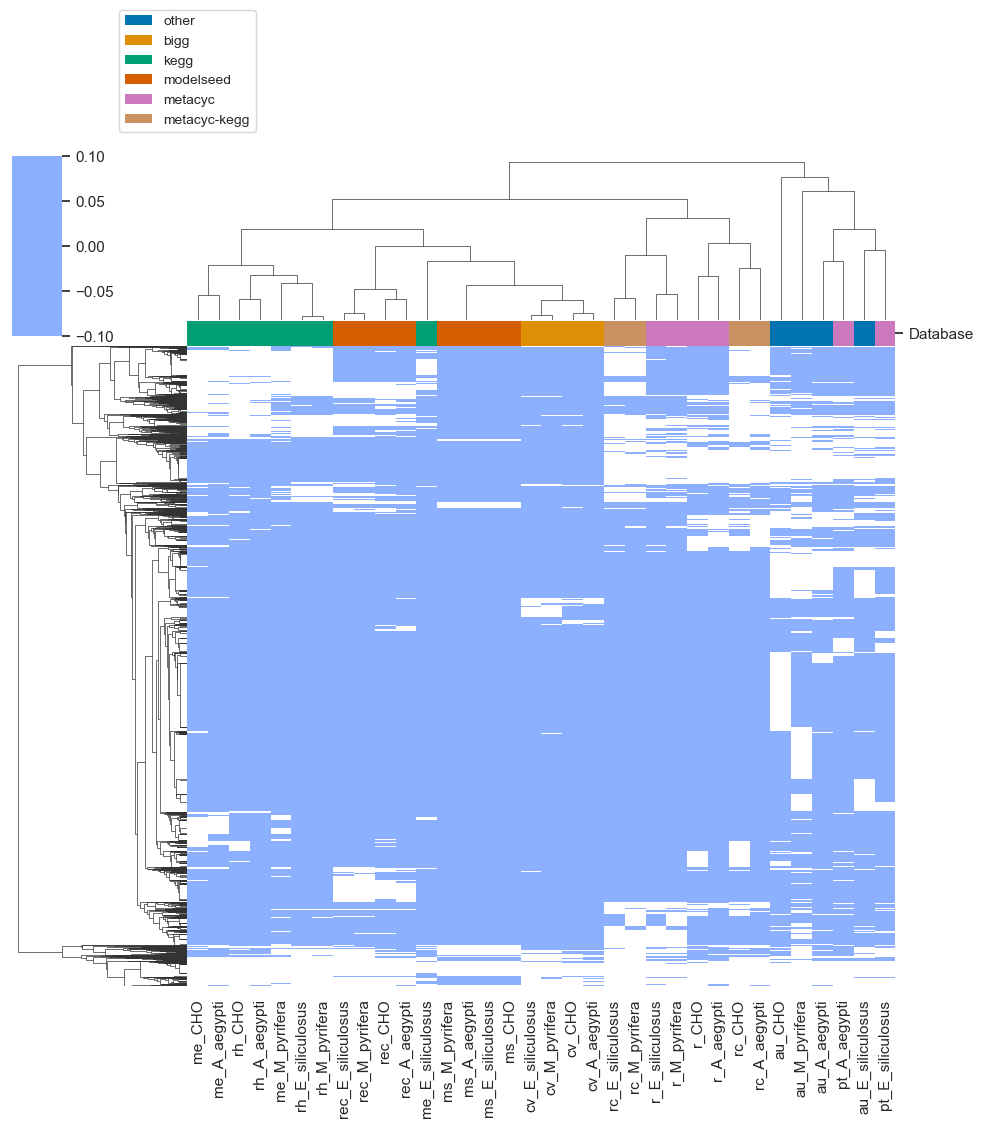

In [148]:
import seaborn as sns
sns.set(font_scale=1)
sns.set_style("white")
#cmap = sns.color_palette("magma_r", 2)
#cmap = sns.color_palette("bwr", 3)
#cmap = sns.color_palette("Blues", 2)
cmap = sns.color_palette('coolwarm',3)
mask = df>0
clustergrid = sns.clustermap(df,method='average', cmap=cmap, center=0, mask = mask, metric='hamming', yticklabels=False, xticklabels=True, col_colors=col_colors)
#clustergrid = sns.clustermap(df,method='average', cmap=cmap, center=0, metric='euclidean', yticklabels=False)
#clustergrid.set_xlabel("X Label",fontsize=30)
# add legends
for label in dbs_plot.unique():
    clustergrid.ax_col_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0);
l1 = clustergrid.ax_col_dendrogram.legend(loc="center", ncol=1, bbox_to_anchor=(0, 1.5), fontsize=10)#, bbox_transform=gcf().transFigure)

#clustergrid.savefig('pathway_tools_terminal_metabolites.pdf')
#clustergrid.savefig('pathway_tools_terminal_reactions.pdf')
clustergrid.savefig('dendograma_preliminar4.pdf')
